# Article Category Classification Based On Its Headline and Keywords

## Loading and Preprocessing Data

In [1]:
import pandas as pd
import numpy as np

#Train 2017
jan2017 = pd.read_csv("/content/ArticlesJan2017.csv")
feb2017 = pd.read_csv("/content/ArticlesFeb2017.csv")
march2017 = pd.read_csv("/content/ArticlesMarch2017.csv")
april2017 = pd.read_csv("/content/ArticlesApril2017.csv")
may2017 = pd.read_csv("/content/ArticlesMay2017.csv")

#Train 2018
jan2018 = pd.read_csv("/content/ArticlesJan2018.csv")
feb2018 = pd.read_csv("/content/ArticlesFeb2018.csv")
march2018 = pd.read_csv("/content/ArticlesMarch2018.csv")

#Test (April 2018)
test_data = pd.read_csv("/content/ArticlesApril2018.csv")

In [2]:
datasets = [jan2017, feb2017, march2017, april2017, may2017, jan2018, feb2018, march2018]
train_data = pd.concat(datasets, ignore_index=True)

In [3]:
train_data

,articleID,abstract,byline,documentType,headline,keywords,multimedia,newDesk,printPage,pubDate,sectionName,snippet,source,typeOfMaterial,webURL,articleWordCount
0,58691a5795d0e039260788b9,NaN,By JENNIFER STEINHAUER,article,G.O.P. Leadership Poised to Topple Obama’s Pi...,"['United States Politics and Government', 'Law...",1,National,1,2017-01-01 15:03:38,Politics,The most powerful and ambitious Republican-led...,The New York Times,News,https://www.nytimes.com/2017/01/01/us/politics...,1324
1,586967bf95d0e03926078915,NaN,By MARK LANDLER,article,Fractured World Tested the Hope of a Young Pre...,"['Obama, Barack', 'Afghanistan', 'United State...",1,Foreign,1,2017-01-01 20:34:00,Asia Pacific,A strategy that went from a “good war” to the ...,The New York Times,News,https://www.nytimes.com/2017/01/01/world/asia/...,2836
2,58698a1095d0e0392607894a,NaN,By CAITLIN LOVINGER,article,Little Troublemakers,"['Crossword Puzzles', 'Boxing Day', 'Holidays ...",1,Games,0,2017-01-01 23:00:24,Unknown,Chuck Deodene puts us in a bubbly mood.,The New York Times,News,https://www.nytimes.com/2017/01/01/crosswords/...,445
3,5869911a95d0e0392607894e,NaN,By JOCHEN BITTNER,article,"Angela Merkel, Russia’s Next Target","['Cyberwarfare and Defense', 'Presidential Ele...",1,OpEd,15,2017-01-01 23:30:27,Unknown,"With a friend entering the White House, Vladim...",The New York Times,Op-Ed,https://www.nytimes.com/2017/01/01/opinion/ang...,864
4,5869a61795d0e03926078962,NaN,By JIAYIN SHEN,article,Boots for a Stranger on a Bus,"['Shoes and Boots', 'Buses', 'New York City']",0,Metro,12,2017-01-02 01:00:02,Unknown,Witnessing an act of generosity on a rainy day.,The New York Times,Brief,https://www.nytimes.com/2017/01/01/nyregion/me...,309
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8006,5ac1647647de81a90121adaa,NaN,By ROBERT LEONARD,article,Will Trump Start a Farm Crisis?,"['Agriculture and Farming', 'International Tra...",1,OpEd,23,2018-04-01 23:00:04,Unknown,Much of rural America will abandon the preside...,The New York Times,Op-Ed,https://www.nytimes.com/2018/04/01/opinion/tru...,849
8007,5ac1654f47de81a90121adb2,NaN,By DENENE MILLNER,article,A New Black American Dream,"['Blacks', 'Parenting', 'Careers and Professio...",1,OpEd,23,2018-04-01 23:03:39,Unknown,We all want our children to have a better life...,The New York Times,Op-Ed,https://www.nytimes.com/2018/04/01/opinion/ame...,865
8008,5ac1700447de81a90121ade2,NaN,By KATIE VAN SYCKLE,article,When a Subject Refuses to Pose,"['Photography', 'New York Times', 'Mattis, Jam...",1,Insider,2,2018-04-01 23:49:21,Unknown,"Mark Peterson, the photographer who worked on ...",The New York Times,News,https://www.nytimes.com/2018/04/01/insider/jim...,611
8009,5ac1720c47de81a90121adf0,NaN,By THE EDITORIAL BOARD,article,America Needs Better Privacy Rules,"['Privacy', 'Social Media', 'United States Pol...",1,Editorial,22,2018-04-01 23:58:02,Unknown,If we learn anything from the recent controver...,The New York Times,Editorial,https://www.nytimes.com/2018/04/01/opinion/fac...,862


In [4]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
train_data['newDesk'] = label_encoder.fit_transform(train_data['newDesk'])
test_data['newDesk'] = label_encoder.transform(test_data['newDesk'])

In [5]:
train_data = train_data[['headline', 'keywords', 'newDesk']]
test_data = test_data[['headline', 'keywords', 'newDesk']]

In [6]:
train_data = train_data.replace(['Unknown', '[]'], np.nan).infer_objects(copy=False)
test_data = test_data.replace(['Unknown', '[]'], np.nan).infer_objects(copy=False)

train_data = train_data.replace(['Unknown', '[]'], np.nan)
test_data = test_data.replace(['Unknown', '[]'], np.nan)

# Drop missing values and duplicates
train_data = train_data.dropna().drop_duplicates()
test_data = test_data.dropna().drop_duplicates()

In [7]:
import nltk

# Download necessary NLTK resources
nltk.download('stopwords')  # Download stopwords
nltk.download('wordnet')  # Download WordNet for lemmatization
nltk.download('averaged_perceptron_tagger')  # Download POS tagger for better lemmatization

from nltk.corpus import wordnet, stopwords
from nltk.stem import WordNetLemmatizer
import re

# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

# A function to get the POS tag to use in lemmatization
def get_wordnet_pos(word):
    """Map POS tag to first character for lemmatizer"""
    tag = nltk.pos_tag([word])[0][1][0].upper()  # Get the POS tag for the word
    tag_dict = {
        'J': wordnet.ADJ,
        'N': wordnet.NOUN,
        'V': wordnet.VERB,
        'R': wordnet.ADV
    }
    return tag_dict.get(tag, wordnet.NOUN)  # Default to NOUN if no tag found

# Define the updated clean_text function with lemmatization
def clean_text(text):
    text = text.lower()  # Convert to lowercase
    # Remove URLs
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text)
    # Remove special characters, punctuation, and apostrophes
    text = re.sub(r"[^a-zA-Z\s]", '', text)
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    # Remove stopwords
    words = text.split()
    stop_words = set(stopwords.words('english'))  # Using pre-installed stopwords
    words = [word for word in words if word not in stop_words]
    # Apply lemmatization
    lemmatized_words = [lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in words]
    return ' '.join(lemmatized_words)  # Rejoin lemmatized words into a single string

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [8]:
import ast

# Ensure keywords column is properly converted from string representations to lists
train_data['keywords'] = train_data['keywords'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# Apply clean_text to both headline and keywords
train_data['headline'] = train_data['headline'].apply(clean_text)
train_data['keywords'] = train_data['keywords'].apply(lambda x: ' '.join([clean_text(word) for word in x]))

test_data['headline'] = test_data['headline'].apply(clean_text)
test_data['keywords'] = test_data['keywords'].apply(lambda x: ' '.join([clean_text(word) for word in x]))


# Combine 'headline' and 'keywords' into a single 'text' column
train_data['text'] = train_data.apply(lambda row: row['headline'] + ' ' + row['keywords'], axis=1)
test_data['text'] = test_data.apply(lambda row: row['headline'] + ' ' + row['keywords'], axis=1)

# Check example output of the first row
print(train_data['text'][0])

gop leadership poise topple obamas pillar united state politics government law legislation house representative senate patient protection affordable care act trump donald j mcconnell mitch


## Data Analysis

In [9]:
from sklearn.model_selection import train_test_split

X = train_data['text']
y = train_data['newDesk']

# Correct order of the split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

Number of unique words: 13612
Selected num_words: 7439


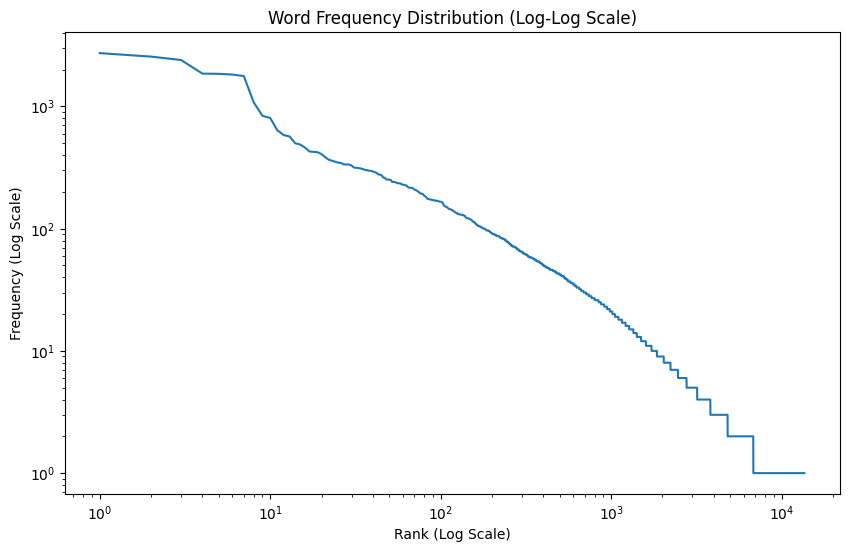

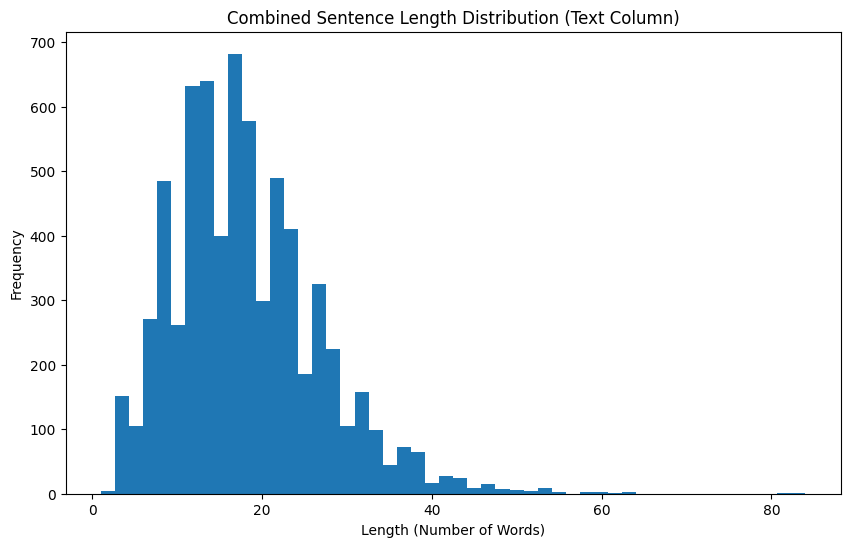

In [10]:
from collections import Counter
import matplotlib.pyplot as plt

# Combine all text fields from the 'text' column and split into words
all_words = ' '.join(train_data['text']).split()

# Use Counter to get word frequencies
word_counts = Counter(all_words)

# Number of unique words
num_unique_words = len(word_counts)
print(f'Number of unique words: {num_unique_words}')

# Analyze word frequency distribution to select num_words
word_freq = sorted(word_counts.values(), reverse=True)

total_words = sum(word_freq)
cumulative_coverage = 0
num_words = 0
for count in word_freq:
    cumulative_coverage += count
    num_words += 1
    if cumulative_coverage / total_words >= 0.95:
        break

print(f'Selected num_words: {num_words}')

# Plot the word frequency distribution (Log-Log Scale)
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(word_freq) + 1), word_freq)
plt.xscale('log')
plt.yscale('log')
plt.title('Word Frequency Distribution (Log-Log Scale)')
plt.xlabel('Rank (Log Scale)')
plt.ylabel('Frequency (Log Scale)')
plt.show()

# Calculate the length of the sentences in the 'text' column (headline + keywords)
sentence_lengths = [len(text.split()) for text in train_data['text']]

# Plot the distribution of combined sentence lengths
plt.figure(figsize=(10, 6))
plt.hist(sentence_lengths, bins=50)
plt.title('Combined Sentence Length Distribution (Text Column)')
plt.xlabel('Length (Number of Words)')
plt.ylabel('Frequency')
plt.show()

In [11]:
y_train.isnull().sum()

0

In [12]:
y_train

,newDesk
3166,14
4925,23
6247,20
7745,41
6099,23
...,...
4490,23
6132,41
6168,11
6353,3


## Modelling

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras import layers, Sequential
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.regularizers import l1
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC, Precision, Recall
from tensorflow.keras.metrics import F1Score  # Correct import from TensorFlow Addons

# Parameters
max_vocab_size = num_words  # Limit on vocabulary size
max_sequence_length = 60  # Max length for each sequence

# Initialize tokenizer and fit on training data
tokenizer = Tokenizer(num_words=max_vocab_size, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

# If you want to know the word_index
# word_index = tokenizer.word_index
# print(word_index)

# Convert text into sequences
X_train_sequences = tokenizer.texts_to_sequences(X_train)

# Pad sequences to ensure uniform length
X_train_padded = pad_sequences(X_train_sequences, maxlen=max_sequence_length, padding='post', truncating='post')

print(X_train_padded[0])
print(X_train_padded.shape)

# Convert integer labels to categorical (one-hot encoding)
y_train_categorical = to_categorical(y_train)
y_val_categorical = to_categorical(y_val)

# Get number of classes from target
num_classes = y_train_categorical.shape[1]

# Processing val data
# Convert text into sequences
X_val_sequences = tokenizer.texts_to_sequences(X_val)

# Pad sequences to ensure uniform length
X_val_padded = pad_sequences(X_val_sequences, maxlen=max_sequence_length, padding='post', truncating='post')

print(X_val_padded[0])
print(X_val_padded.shape)

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import layers

embedding_dim = 500
num_classes = 44

model = tf.keras.Sequential([
    layers.Embedding(max_vocab_size, embedding_dim),

    # Convolutional Layers for feature extraction
    layers.Conv1D(filters=128, kernel_size=5, activation='relu'),
    layers.MaxPooling1D(pool_size=2),
    layers.Conv1D(filters=128, kernel_size=5, activation='relu'),
    layers.MaxPooling1D(pool_size=2),

    # Bidirectional LSTM for capturing sequential dependencies
    layers.Bidirectional(layers.LSTM(128, return_sequences=True)),
    layers.Bidirectional(layers.LSTM(128)),

    # Fully Connected Layers with regularization
    layers.BatchNormalization(),
    layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    layers.Dropout(0.5),
    layers.BatchNormalization(),
    layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    layers.Dropout(0.5),

    # Output Layer
    layers.Dense(num_classes, activation='softmax')
])

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=0.001),  # Reduced learning rate
              metrics=['accuracy', Precision(name='precision'), Recall(name='recall'), F1Score(average='weighted')] )

# Early Stopping
early_stopping = EarlyStopping(
    patience=5,
    min_delta=0.001,
    restore_best_weights=True
)

# Learning Rate Scheduler
lr_scheduler = ReduceLROnPlateau(
    factor=0.5,
    patience=3,
    min_lr=1e-6
)

history = model.fit(
    X_train_padded,
    y_train_categorical,
    epochs=50,
    validation_data=(X_val_padded, y_val_categorical),
    callbacks=[early_stopping, lr_scheduler],
    verbose=2
)

[ 398  581   49 2402   90  840  879  123   15   15   25  186  128  197
   23   49 2402    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0]
(5452, 60)
[1703  193 4813  110  166 1628  193    1 4603 1400    1   41  925    1
  841  925 2331    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0]
(1364, 60)
Epoch 1/50
171/171 - 57s - 331ms/step - accuracy: 0.2058 - f1_score: 0.1771 - loss: 8.0825 - precision: 0.3643 - recall: 0.0756 - val_accuracy: 0.2067 - val_f1_score: 0.0780 - val_loss: 6.6895 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/50
171/171 - 79s - 463ms/step - accuracy: 0.4442 - f1_score: 0.3988 - loss: 4.7465 - pre

In [ ]:
model.save('/content/Model/my_model')  # No need for the .h5 extension

In [ ]:
import matplotlib.pyplot as plt

# Plot accuracy over epochs
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss over epochs
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

sequences_test = tokenizer.texts_to_sequences(test_data['text'])
sequences_padded = pad_sequences(sequences_test, maxlen=max_sequence_length, padding='post', truncating='post')

y_test = test_data['newDesk']

In [ ]:
# Get predictions on the test dataset
test_predictions = model.predict(sequences_padded)

# Convert the predicted probabilities to class labels (numerical form)
predicted_test_classes = np.argmax(test_predictions, axis=1)

# Map the predicted numeric labels back to original string labels
predicted_test_labels = label_encoder.inverse_transform(predicted_test_classes)

# Map the true test labels back to their original string form for comparison
true_test_labels = label_encoder.inverse_transform(y_test)

In [ ]:
# Display predicted and actual string labels side by side
print("Predicted Test Labels:", predicted_test_labels)
print("True Test Labels:", true_test_labels)

# Optionally, calculate accuracy or other metrics
from sklearn.metrics import accuracy_score
test_accuracy = accuracy_score(true_test_labels, predicted_test_labels)
print(f"Test Accuracy: {test_accuracy:.2f}")